In [ ]:
import time, torch, numpy as np
import matplotlib as mpl, matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import tensor ,nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import coremltools as ct
from PIL import Image

### Configure GPU acceleration

In [2]:
# cuda: NVIDIA GPUs, mps: Metal Performance Shaders (Apple M GPUs), cpu: generic CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


### Import MNIST data

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=True)

#### Create tensors for training and testing from data

In [4]:
x_train, y_train = next(iter(trainloader))
x_test, y_test = next(iter(testloader))
x_train.shape

torch.Size([50000, 1, 28, 28])

In [5]:
x_train = x_train.view(50000,-1)
x_test = x_test.view(10000,-1)
x_train.shape

torch.Size([50000, 784])

tensor(7)


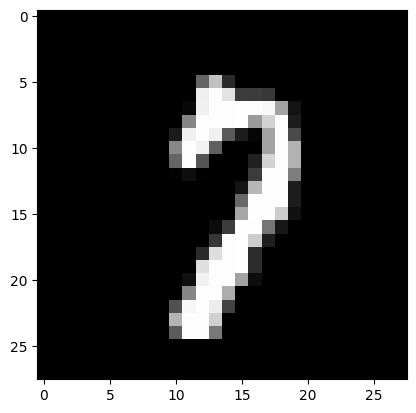

In [6]:
print(y_train[500])
xsq = x_train.reshape((-1,28,28)).to(torch.device("cpu"))
_ = plt.imshow(xsq[500].view(28,28), cmap='gray')

## Neural Network

### Configure network

In [7]:
# construct the model
nin = x_train.shape[1]
nout = int(np.max(y_train.numpy())+1)

# Create Net class
# nin: dimension of input data
# nout: number of outputs
class Net(nn.Module):
    def __init__(self,nin,nout):
        super(Net,self).__init__()
        self.sigmoid = nn.ReLU()
        self.Dense1 = nn.Linear(nin,800)
        self.Dense2 = nn.Linear(800, nout)
        self.dropout1 = nn.Dropout(p=0.0025)
        
    def forward(self,x):
        # flatten image input
        x = x.view(x.size(0), -1)
        # layer 1
        x = self.sigmoid(self.Dense1(x))
        x = self.dropout1(x)
        # layer 2
        out = self.Dense2(x)
        return out

# Initialize network
model = Net(nin=nin, nout=nout)

# Print string representation
print(str(model))

Net(
  (sigmoid): ReLU()
  (Dense1): Linear(in_features=784, out_features=800, bias=True)
  (Dense2): Linear(in_features=800, out_features=10, bias=True)
  (dropout1): Dropout(p=0.0025, inplace=False)
)


### Prepare dataloader

In [8]:
x_train = x_train.view(50000,-1).to(device)
y_train = y_train.to(device)

train_ds = torch.utils.data.TensorDataset(x_train, y_train)

# Create a training/test data loader from datasets
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=100, shuffle=True)

### Train model

In [9]:
%%time

model.to(device)

lr = 1e-3
opt = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

a_tr_loss = []
a_tr_accuracy = []

num_epoch = 100

for epoch in range(num_epoch):
    model.train() # put model in training mode
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    batch_loss_tr = []
    # iterate over training set
    for train_iter, data in enumerate(train_loader):
        x_batch, y_batch = data
        y_batch = y_batch.type(torch.long)
        out = model(x_batch)
        # Compute Loss
        loss = criterion(out, y_batch)
        batch_loss_tr.append(loss.item())
        # Compute gradients using back propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        # Do hard classification: index of largest score
        _, predicted = torch.max(out.data, 1)
        # Compute number of decision errors
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
    a_tr_loss.append(np.mean(batch_loss_tr)) # Compute average loss over epoch
    a_tr_accuracy.append(100*correct/total)

    if ((epoch+1) % 10 == 0) or (epoch == 0):
        print('\nEpoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch])
          +'Train Acc: {0:.2f}   '.format(a_tr_accuracy[epoch]))
    elif ((epoch+1) % 1 == 0):
        print('=', end='')


Epoch:  1   Train Loss: 0.339   Train Acc: 89.78   
Epoch: 10   Train Loss: 0.038   Train Acc: 98.71   
Epoch: 20   Train Loss: 0.019   Train Acc: 99.34   
Epoch: 30   Train Loss: 0.015   Train Acc: 99.48   
Epoch: 40   Train Loss: 0.015   Train Acc: 99.47   
Epoch: 50   Train Loss: 0.007   Train Acc: 99.79   
Epoch: 60   Train Loss: 0.013   Train Acc: 99.57   
Epoch: 70   Train Loss: 0.006   Train Acc: 99.81   
Epoch: 80   Train Loss: 0.011   Train Acc: 99.70   
Epoch: 90   Train Loss: 0.004   Train Acc: 99.88   
Epoch: 100   Train Loss: 0.005   Train Acc: 99.84   
CPU times: user 6min 33s, sys: 36.4 s, total: 7min 9s
Wall time: 8min 59s


#### Evaluate model accuracy on test data

In [10]:
# compute the training accuracy
with torch.no_grad():
    predict = model(x_test.to(device)).cpu().detach().numpy().argmax(axis=1)
acc = np.mean(predict==y_test.numpy())
print('training accuracy: ',acc)

training accuracy:  0.9792


## Export as Core ML
In order to use this model in an Xcode app, it must be converted to Core ML

#### Wrap trained model with softmax on output
After the model is trained, we want to add softmax to the output.
This is so that the CoreML model can output probabilities which can be used later by an app, for example.

In [11]:
class SoftmaxWrapper(nn.Module):
    def __init__(self, model):
        super(SoftmaxWrapper, self).__init__()
        self.model = model
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        logits = self.model(input)
        probabilities = self.softmax(logits)
        return probabilities

# wrap trained model
model_with_softmax = SoftmaxWrapper(model)

### Convert to Core ML

In [12]:
model_with_softmax.eval()

# create an example input tensor
example_input = torch.rand(1, 1, 28, 28)

# convert model to TorchScript via tracing
traced_model = torch.jit.trace(model_with_softmax.cpu(), example_input)

# convert TorchScript model to CoreML
coreml_model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[ct.ImageType(name="Input", 
                         shape=(1, 1, 28, 28), 
                         color_layout=ct.colorlayout.GRAYSCALE, 
                         bias=0.5
                        )],
    classifier_config = ct.ClassifierConfig(class_labels=list(range(10)), predicted_feature_name="Prediction"),
)

Running MIL default pipeline:   0%|                                                         | 0/71 [00:00<?, ? passes/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:267: UserWarning: Output, '22', of the source model, has been renamed to 'var_22' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|███████████████████████████████████| 12/12 [00:00<00:00, 14904.25 passes/s]


#### Add metadata

In [13]:
coreml_model.input_description["Input"] = "Input image containing a white number on a black background"
coreml_model.output_description["Prediction"] = "Predicted number"

coreml_model.author = "Dhruv Weaver"

# coreml_model.license = ""

coreml_model.short_description = "Classifies written numbers using a model trained on MNIST dataset"

# set the preview type
coreml_model.user_defined_metadata["com.apple.coreml.model.preview.type"] = "imageClassifier"

coreml_model.version = "0.1"

#### Test converted model

In [14]:
img = Image.open("image.jpg")
display(img)
prediction = coreml_model.predict({"Input" : img})['Prediction']
print(f'Prediction: {prediction}')
print('Probabilites:')
# print(coreml_model.predict({"Input" : img})['Prediction_probs'])
print(coreml_model.predict({"Input" : img}))

Prediction: 1
Probabilites:
{'Prediction': 1, 'var_22': array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), 'Prediction_probs': {0: 0.0, 9: 0.0, 5: 0.0, 1: 1.0, 6: 0.0, 2: 0.0, 7: 0.0, 3: 0.0, 8: 0.0, 4: 0.0}}


### Export model

In [15]:
# Save the CoreML model
coreml_model.save('MNIST.mlpackage')